# Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

#### Notebook destinado a análise de Pré Treinamento dos Stacked Autoencoder (SAE)

In [1]:
import os
import sys
import time
from datetime import datetime, timedelta
sys.path.insert(0,'..')

from noveltyDetectionConfig import CONFIG
import numpy as np
import itertools
import multiprocessing
import pprint 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
import matplotlib.pyplot as plt

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14

from SAENoveltyDetectionAnalysis import SAENoveltyDetectionAnalysis

num_processes = multiprocessing.cpu_count()

from Functions.telegrambot import Bot

my_bot = Bot("lisa_thebot")

pp = pprint.PrettyPrinter(indent=1)

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']


training_params = {
    "Technique": "StackedAutoEncoder"
}

analysis = SAENoveltyDetectionAnalysis(parameters=training_params, model_hash="cadc84ee1837f4aa2919c45f8cdf287fcb18166212d57eb4d47e47c6a0bb0450",
                                       load_hash=True, load_data=True, verbose=False)
all_data, all_trgt, trgt_sparse = analysis.getData()

SAE = analysis.createSAEModels()

trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

Using TensorFlow backend.


Reading from /home/vinicius.mello/Workspace/SonarAnalysis_2/Results/NoveltyDetection/StackedAutoEncoder/outputs/cadc84ee1837f4aa2919c45f8cdf287fcb18166212d57eb4d47e47c6a0bb0450/parameters.json
[+] Time to read data file: 1.24436497688 seconds
Balacing data...
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [2]:
print analysis.getBaseResultsPath()
pp.pprint(analysis.parameters)

/home/vinicius.mello/Workspace/SonarAnalysis_2/Results/NoveltyDetection/StackedAutoEncoder/outputs/cadc84ee1837f4aa2919c45f8cdf287fcb18166212d57eb4d47e47c6a0bb0450
{u'DevelopmentEvents': 400,
 u'DevelopmentMode': False,
 u'HyperParameters': {u'batch_size': 128,
                      u'bias_initializer': u'ones',
                      u'classifier_output_activation_function': u'sigmoid',
                      u'decoder_activation_function': u'tanh',
                      u'dropout': False,
                      u'dropout_parameter': 0.0,
                      u'encoder_activation_function': u'tanh',
                      u'kernel_initializer': u'uniform',
                      u'loss': u'mean_squared_error',
                      u'metrics': [u'accuracy'],
                      u'n_epochs': 500,
                      u'n_folds': 4,
                      u'n_inits': 1,
                      u'norm': u'mapstd',
                      u'regularization': None,
                      u'regular

### Mean Squared Error for a neuron variation at autoencoder (Known vs Novelty)

[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...
[*] Calculating Mean Squared Error ...


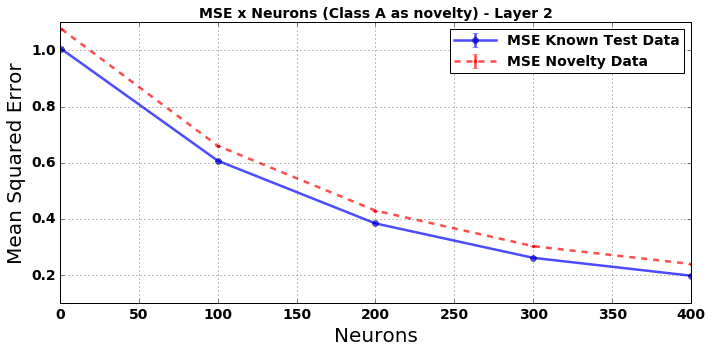

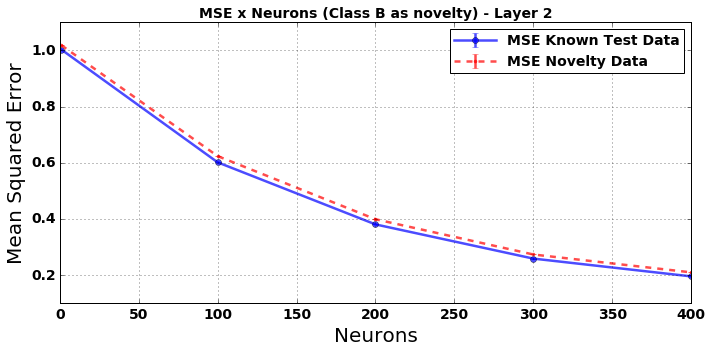

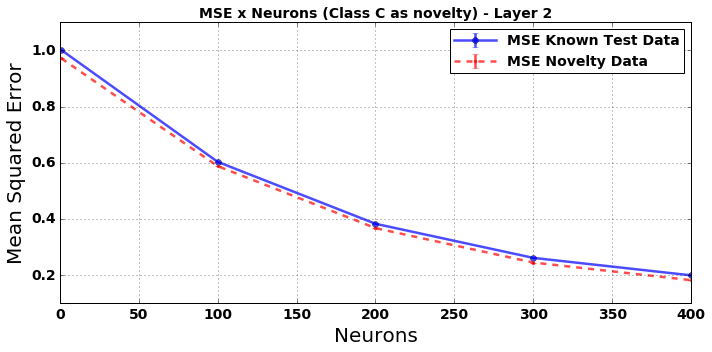

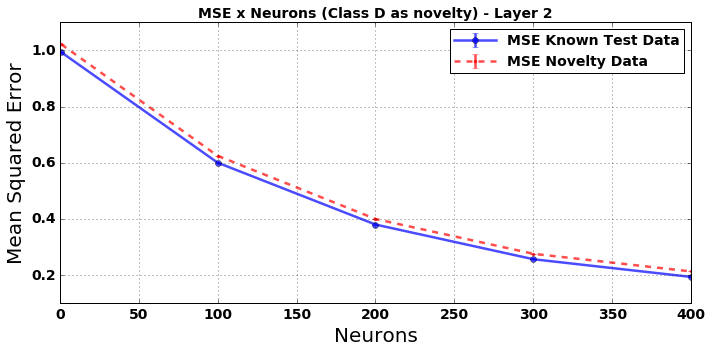

In [3]:
# Neuron variation x MSE Divergence
%matplotlib inline 


# Choose layer 
layer = 2

# Choose neurons topology
# hidden_neurons = range(400,0,-50) + [2]
hidden_neurons = [400,400]

step = 100
neurons_mat = [1] + range(step,hidden_neurons[layer-1]+step,step)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

analysis_name = 'mean_squared_error_%i_layer'%(layer)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

# os.remove(analysis_file)

verbose = True

m_colors = ['b', 'r', 'g', 'y']
figsize = (10,5)

mse = {}
mse_known = np.zeros([len(analysis.class_labels), analysis.n_folds, len(neurons_mat)])
mse_novelty = np.zeros([len(analysis.class_labels), analysis.n_folds, len(neurons_mat)])

if not os.path.exists(analysis_file):
    for inovelty in range(len(analysis.class_labels)):
        n_bins = 100
        for ineuron in neurons_mat: 
            if ineuron == 0:
                ineuron = 1
            def getMSE(ifold):
                train_id, test_id = analysis.CVO[inovelty][ifold]
                
                scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)

                known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
                novelty_data = scaler.transform(all_data[all_trgt==inovelty])

                model = SAE[inovelty].get_model(data=trn_data[inovelty], trgt=trn_trgt[inovelty],
                                                hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                                layer=layer, ifold=ifold)

                known_output = model.predict(known_data)
                novelty_output = model.predict(novelty_data)

                mseKnown = metrics.mean_squared_error(known_data, known_output)
                mseNovelty = metrics.mean_squared_error(novelty_data, novelty_output)

                return ifold, mseKnown, mseNovelty

            # Start Parallel processing
            p = multiprocessing.Pool(processes=num_processes)

            folds = range(len(analysis.CVO[inovelty]))
            if verbose:
                print '[*] Calculating Mean Squared Error ...'
            mse[ineuron] = p.map(getMSE, folds)

            for ifold in range(analysis.n_folds):
                mse_known[inovelty,:, neurons_mat.index(ineuron)] = mse[ineuron][ifold][1]
                mse_novelty[inovelty,:, neurons_mat.index(ineuron)] = mse[ineuron][ifold][2]

            p.close()
            p.join()
    
    joblib.dump([neurons_mat,mse_known,mse_novelty],analysis_file,compress=9)
else:
    [neurons_mat, mse_known, mse_novelty] = joblib.load(analysis_file)

for inovelty in range(len(analysis.class_labels)):
    
    # Plot results    
    fig = plt.subplots(figsize=figsize)
    ax = plt.subplot(1,1,1)

    ax.errorbar(neurons_mat, np.mean(mse_known[inovelty], axis=0),
                np.std(mse_known[inovelty], axis=0),fmt='o-',
                color='b',alpha=0.7,linewidth=2.5,
                label='MSE Known Test Data')
    ax.errorbar(neurons_mat, np.mean(mse_novelty[inovelty], axis=0),
                np.std(mse_novelty[inovelty], axis=0),fmt='.--',
                color='r',alpha=0.7,linewidth=2.5,
                label='MSE Novelty Data')

    ax.set_title('MSE x Neurons (Class {} as novelty) - Layer {}'.format(analysis.class_labels[inovelty], layer),
                 fontsize=14, fontweight='bold')

    ax.set_ylabel('Mean Squared Error', fontsize=20)
    ax.set_xlabel('Neurons', fontsize=20)
    ax.grid()
    ax.legend()
    plt.tight_layout()


    #Save the figure
    neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
    file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty_{}_neurons.png".format(inovelty,neurons_str))
    plt.savefig(file_name, format="png")
    try:
        my_bot.sendMessage(imgPath=file_name)
    except Exception as e:
        print("Error when sending message to the Bot: {}".format(str(e)))
    plt.show()

### Mean Squared Error for a neuron variation at autoencoder (Classes vs Novelty)

### Lofargram (Original vs Reconstructed data)

Error when sending message to the Bot: Timed out


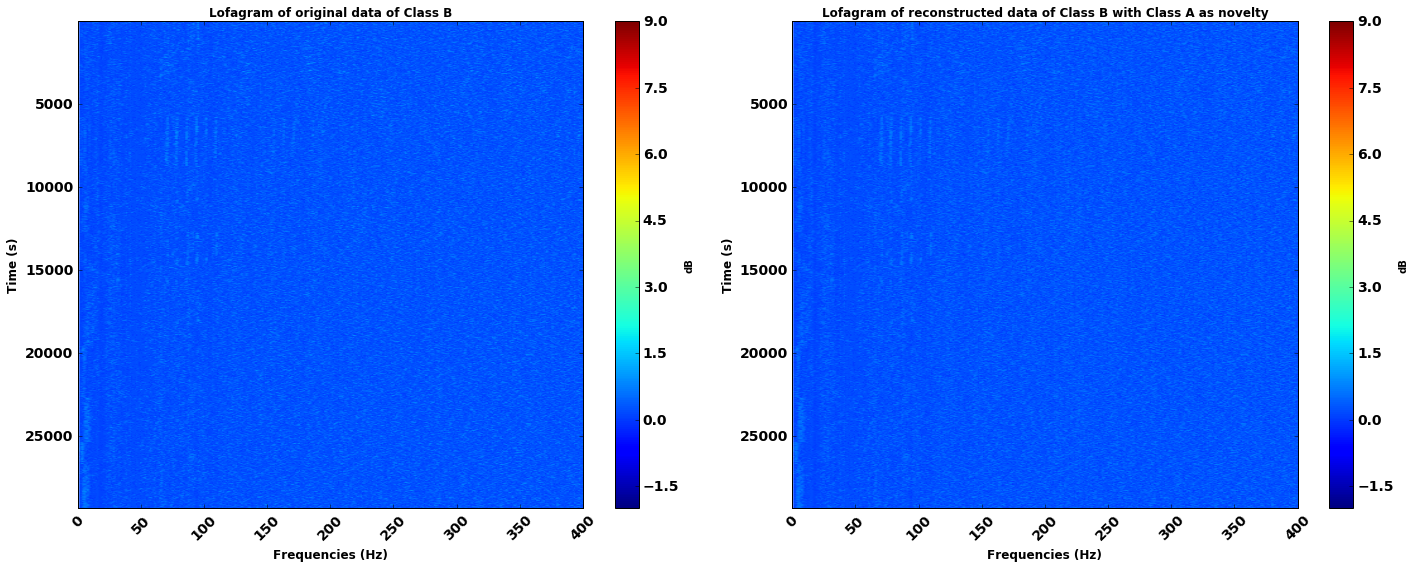

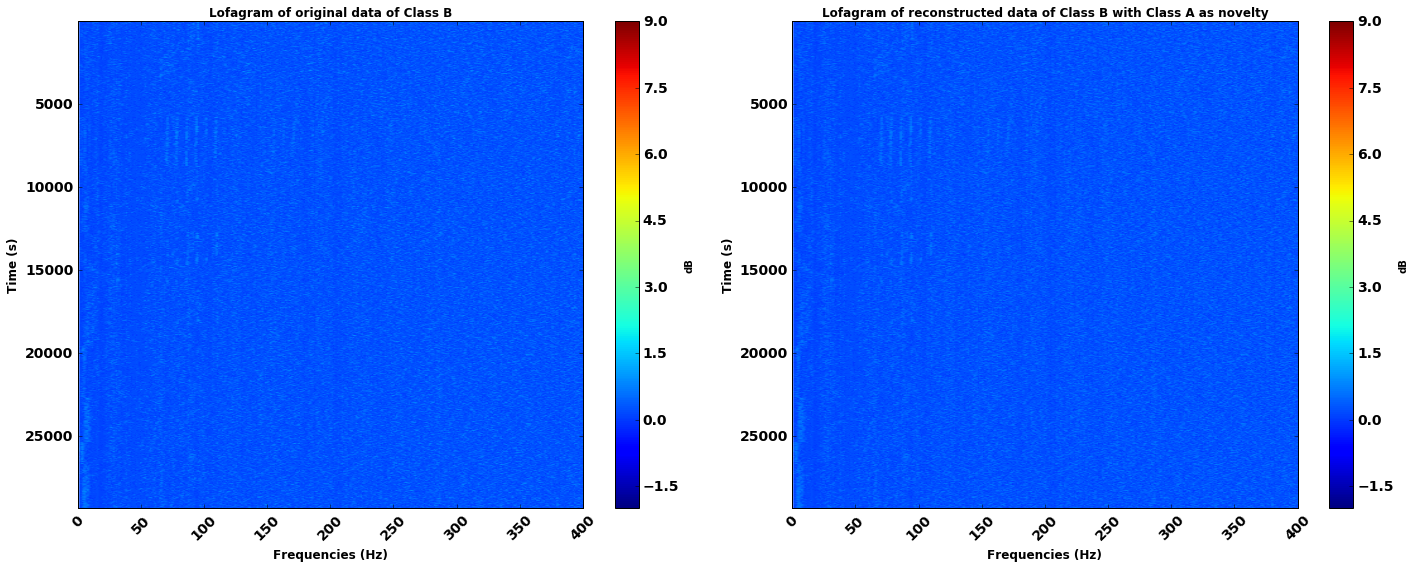

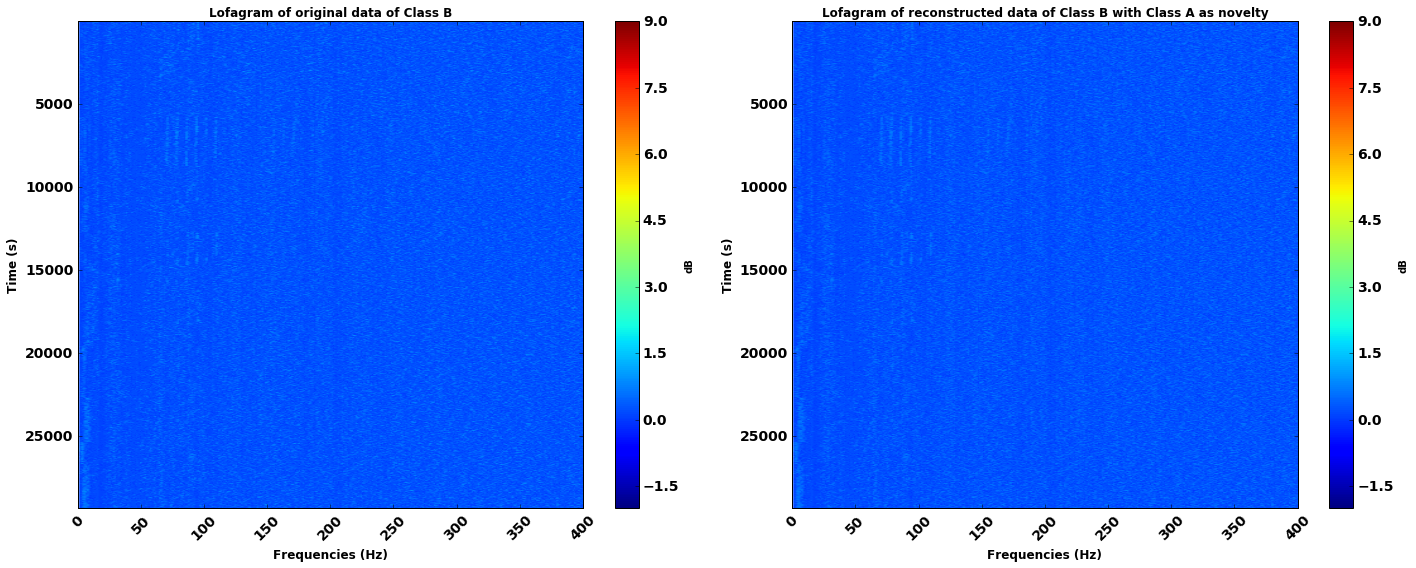

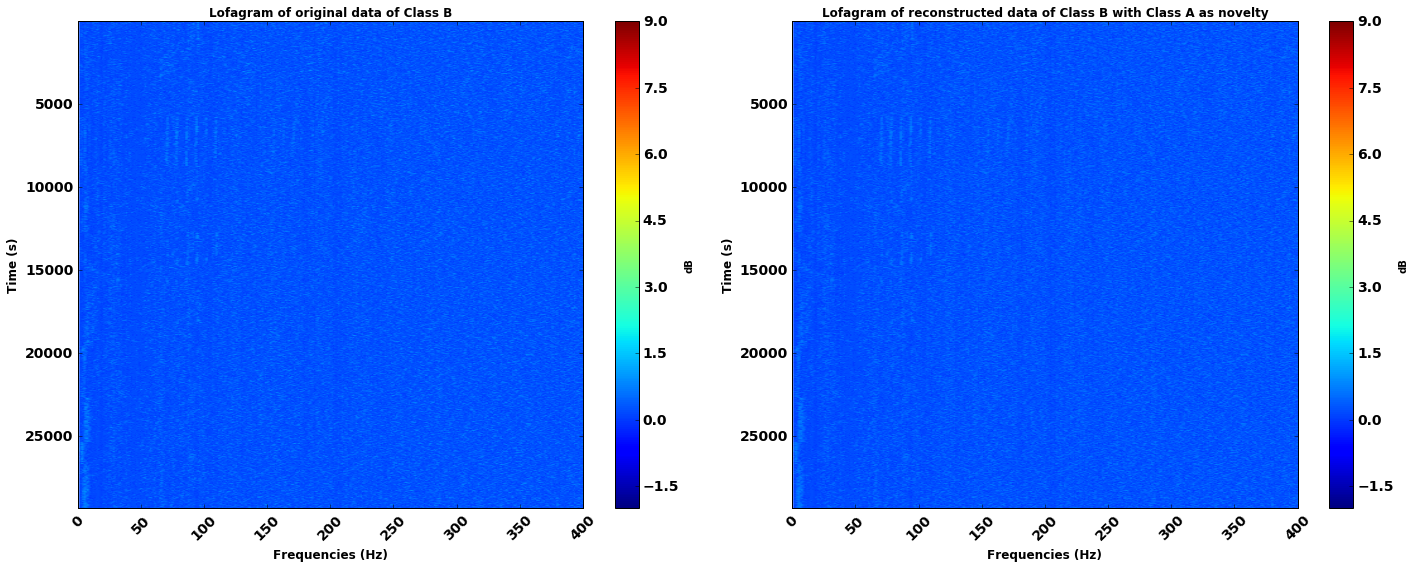

In [5]:
# LOFARGRAM
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
import matplotlib.pyplot as plt

# Choose model
layer = 1

inovelty = 0
iclass = 1

hidden_neurons = range(400,0,-50) + [2]
hidden_neurons = [400]

analysis_name = 'lofargram_{}_layer_{}_inovelty_{}_class'.format(layer, inovelty, iclass)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

# os.remove(analysis_file)
    
for ifold in range(len(analysis.CVO[inovelty])):
    scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)
    data = scaler.transform(all_data[all_trgt==iclass])
#     data = all_data[all_trgt==iclass]
#     novelty_data = scaler.transform(all_data[all_trgt==inovelty])

    model = SAE[inovelty].get_model(data=trn_data[inovelty], trgt=trn_trgt[inovelty],
                                    hidden_neurons=hidden_neurons[:layer],
                                    layer=layer, ifold=ifold)
    
    output = model.predict(data)

    m_fontsize = 12

    fig, subplot_array = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        if i == 0:
            plt.imshow(data,
               cmap="jet",extent=[1, 400, data.shape[0],1],
               aspect="auto")
            plt.title('Lofagram of original data of Class %s'%(analysis.getClassLabels()[iclass]), fontsize= m_fontsize, fontweight="bold")
        if (i == 1):
            plt.imshow(output,
               cmap="jet",extent=[1, 400, output.shape[0],1],
               aspect="auto")
            plt.title('Lofagram of reconstructed data of Class %s with Class %s as novelty'%(analysis.getClassLabels()[iclass],analysis.getClassLabels()[inovelty]), fontsize= m_fontsize, fontweight="bold")
        
        plt.ylabel('Time (s)', fontsize= m_fontsize, fontweight="bold")
        plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")

#         # Plot lines at frequencies with high errors
#         for index in indexes[:points]:
#             plt.axvline(index, color='r', alpha=0.7)
            
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
    plt.tight_layout()
    #Save the figure
    neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
    file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_neurons_{}_ifold.png".format(neurons_str,ifold))
    plt.savefig(file_name, format="png")
    try:
        my_bot.sendMessage(imgPath=file_name)
    except Exception as e:
        print("Error when sending message to the Bot: {}".format(str(e)))
    
    plt.show()

### 2D Visualization with PCA

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

FIG_SIZE = (16, 8)

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = [400]

step = 100
neurons_mat = range(step,hidden_neurons[layer-1]+step,step)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

for inovelty in range(len(analysis.getClassLabels())):
    ifold = 0
    for ineuron in neurons_mat:
        train_id, test_id = analysis.CVO[inovelty][ifold]
        neurons_str = SAE[inovelty].get_neurons_str(data=trn_data[inovelty],
                                                    hidden_neurons=hidden_neurons[:layer-1]+[ineuron])

        scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)

        # Make a train/test split using CVO
        known_data_train = scaler.transform(trn_data[inovelty][train_id,:]) 
        known_trgt_train = trn_trgt[inovelty][train_id]

        known_data_test  = scaler.transform(trn_data[inovelty][test_id,:])
        known_trgt_test  = trn_trgt[inovelty][test_id]

        novelty_data = scaler.transform(all_data[all_trgt==inovelty])

        # Get encoded data
        model = SAE[inovelty].get_stacked_encoder(data=trn_data[inovelty], trgt=trn_trgt[inovelty],
                                                  hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                                  layer=layer, ifold=ifold)

        encoded_known_data_train = model.predict(known_data_train) 
        encoded_known_data_test = model.predict(known_data_test) 
        encoded_novelty_data = model.predict(novelty_data) 

        # Fit to original data using PCA

        print("Finding the PCA...")
        original_clf = make_pipeline(PCA(n_components=2))
        original_clf.fit(known_data_train, known_trgt_train)

        # Fit to encoded data using and PCA.
        encoded_clf = make_pipeline(PCA(n_components=2))
        encoded_clf.fit(encoded_known_data_train, known_trgt_train)

        print("Extracting the PCA from the pipeline...")
        # Extract PCA from pipeline
        pca_original = original_clf.named_steps['pca']
        pca_encoded = encoded_clf.named_steps['pca']

        print("Transforming the data...")
        # Use PCA on known_data_train data for visualization.
        known_data_train_pca = pca_original.transform(known_data_train)
        known_data_test_pca = pca_original.transform(known_data_test)
        novelty_data_pca = pca_original.transform(novelty_data)

        encoded_known_data_train_pca = pca_encoded.transform(encoded_known_data_train)
        encoded_known_data_test_pca = pca_encoded.transform(encoded_known_data_test)
        encoded_novelty_data_pca = pca_encoded.transform(encoded_novelty_data)

        # visualize encoded vs. original dataset with PCA performed
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)

        m_colors = ['b', 'r', 'g', 'y']
        markers = ['^', 's', 'o', 'p']

        for iclass in range(len(analysis.getClassLabels())):
            if iclass == inovelty: 
                ax1.scatter(novelty_data_pca[:,0], novelty_data_pca[:, 1],
                            color='black',
                            label='Novelty Class',
                            alpha=0.3,
                            marker=markers[iclass]
                            )        
            else:
                ax1.scatter(known_data_test_pca[known_trgt_test == iclass, 0], known_data_test_pca[known_trgt_test == iclass, 1],
                            color=m_colors[iclass],
                            label='Class %s' % analysis.getClassLabels()[iclass],
                            alpha=0.3,
                            marker=markers[iclass]
                            )
            # Second subfigure
            if iclass == inovelty: 
                ax2.scatter(encoded_novelty_data_pca[:,0], encoded_novelty_data_pca[:, 1],
                            color='black',
                            label='Novelty Class',
                            alpha=0.3,
                            marker=markers[iclass]
                            )
            else:
                ax2.scatter(encoded_known_data_test_pca[known_trgt_test == iclass, 0], encoded_known_data_test_pca[known_trgt_test == iclass, 1],
                            color=m_colors[iclass],
                            label='Class %s' % analysis.getClassLabels()[iclass],
                            alpha=0.3,
                            marker=markers[iclass]
                            )

        ax1.set_title('Original Feature Space - Fold {}'.format(ifold+1),fontsize=14, fontweight='bold')
        ax2.set_title('New Feature Space ({}) - {} Layer - Fold {}'.format(neurons_str, layer, ifold+1),fontsize=14, fontweight='bold')

        for ax in (ax1, ax2):
            ax.set_xlabel('1st principal component', fontsize=16)
            ax.set_ylabel('2nd principal component', fontsize=16)
            ax.legend(loc='upper right')
            ax.grid()

        plt.tight_layout()

        file_name = os.path.join(analysis.pictures_output_folder,"first_2_principal_components"+"_{}_novelty_{}_neurons.png".format(inovelty,neurons_str))
        plt.savefig(file_name, format="png")
        try: 
            my_bot.sendMessage(imgPath=file_name)
        except Exception as e:
            print("Error when sending the image to the bot. Error: {}".format(str(e)))

### 2D Visualization with SAE

In [ ]:
def plot_latentSpace(encoder, x_test, y_test, batch_size):
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
    plt.colorbar()
    plt.show()

### Original vs Reconstructed data for the features with the highest MSE

### Mutual Information Analysis for a neuron variation at autoencoder